In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
accuracies = []
matrices = []

# Load the data
poker = pd.read_csv(
    'poker-hand-training-true.data', 
    header=None, 
    names=['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS']
)

poker_test = pd.read_csv(
    'poker-hand-testing.data', 
    header=None, 
    names=['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS']
)

x_train = poker.drop('CLASS', axis=1)
y_train = poker['CLASS']
x_test = poker_test.drop('CLASS', axis=1)
y_test = poker_test['CLASS']

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
sample_weights = compute_sample_weight('balanced', y_train)
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
# Stack model
# First level estimators
estimators = [
    ('rf1', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced'
    )),
    ('rf2', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=2,
        class_weight='balanced'
    )),
    ('dt', DecisionTreeClassifier(
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced'
    ))
]

# Stack them with a final estimator
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

In [6]:
dt.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = dt.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 0.49
Train accuracy: 1.00
Predicted       0       1      2      3     4     5     6    7    8    9
Actual                                                                  
0          287647  184159  17990   7908  1291  1448   609   74   24   59
1          181877  196724  28371  11029  2044   883  1156  169   37  208
2           14958   24810   5212   1807   449    55   274   26    5   26
3            6311   10304   1772   2241   240    17   166   43    2   25
4            1125    1912    385    249   144     9    26    2    8   25
5             977     514     51     28     7   310     0    0  108    1
6             311     730    194    142    26     2    16    3    0    0
7              29     118     24     48     6     0     3    1    0    1
8               2       5      2      0     1     2     0    0    0    0
9               1       1      1      0     0     0     0    0    0    0


In [7]:
rf.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = rf.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 0.60
Train accuracy: 1.00
Predicted       0       1    2   3   4   5  6  7  9
Actual                                             
0          403625   97568   14   0   1   1  0  0  0
1          228922  193353  178  31  11   0  1  0  2
2           15141   32367  108   6   0   0  0  0  0
3            4738   16293   12  77   0   0  0  1  0
4             647    3227    5   0   3   0  0  0  3
5            1766     134    0   0   0  96  0  0  0
6             144    1269    6   5   0   0  0  0  0
7               7     215    2   6   0   0  0  0  0
8               5       5    0   0   0   2  0  0  0
9               1       2    0   0   0   0  0  0  0


In [8]:
stack.fit(x_train, y_train)

# Predict the test data
y_pred = stack.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

c:\Users\Ethan\miniconda3\envs\test\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.62
Train accuracy: 1.00
Predicted       0       1    2    3  4    5
Actual                                     
0          377291  123903    0    1  0   14
1          175881  246164  136  312  2    3
2            8320   38741  175  386  0    0
3            2160   18140   86  735  0    0
4             120    3761    1    3  0    0
5            1340     261    0    0  0  395
6              29    1247   30  118  0    0
7               0     177    4   49  0    0
8               1       8    0    0  0    3
9               1       2    0    0  0    0


---

In [9]:
def create_feats(df):
    ''' Create features for the poker hand dataset '''
    df_copy = df.copy()
    # count cards of same rank
    for card in range (1, 14):
        df_copy[f'card {card}'] = df_copy[[f'C{i}' for i in range(1, 6)]].eq(card).sum(axis=1)
    # count cards of same suit
    for suit in range (1, 5):
        df_copy[f'suit {suit}'] = df_copy[[f'S{i}' for i in range(1, 6)]].eq(suit).sum(axis=1)
    # check sequential
    df_copy['sorted_rank'] = df_copy.apply(lambda row: sorted([row[f'C{i}'] for i in range(1, 6)]), axis=1)
    df_copy['is_sequental'] = df_copy['sorted_rank'].apply(lambda x: all(x[i+1] - x[i] == 1 for i in range(len(x)-1)))
    df_copy['is_sequental'] = df_copy.apply(
        lambda row: True if row['sorted_rank'] == [1, 10, 11, 12, 13] else row['is_sequental'], axis=1
    )
    df_copy.drop(['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'sorted_rank'], axis=1, inplace=True)
    return df_copy

In [10]:
poker_after = create_feats(poker)
poker_test_after = create_feats(poker_test)

x_train = poker_after.drop('CLASS', axis=1)
y_train = poker_after['CLASS']
x_test = poker_test_after.drop('CLASS', axis=1)
y_test = poker_test_after['CLASS']

In [11]:
dt.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = dt.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 0.97
Train accuracy: 1.00
Predicted       0       1      2      3     4     5    6   7   8   9
Actual                                                              
0          501209       0      0      0     0     0    0   0   0   0
1               0  414375   8123      0     0     0    0   0   0   0
2               0   15309  32313      0     0     0    0   0   0   0
3               0       0      0  20159     0     0  962   0   0   0
4               0       0      0      0  3775     0    0   0  89  21
5               0       0      0      0     0  1996    0   0   0   0
6               0       7    125   1071     0     0  221   0   0   0
7               0       0      0    124     0     0   14  92   0   0
8               0       0      0      0    11     0    0   0   1   0
9               0       0      0      0     0     0    0   0   0   3


In [12]:
rf.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = rf.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 0.97
Train accuracy: 1.00
Predicted       0       1      2      3     4     5   6   7  9
Actual                                                        
0          501209       0      0      0     0     0   0   0  0
1               0  422498      0      0     0     0   0   0  0
2               0   30892  16730      0     0     0   0   0  0
3               0     523      0  20589     0     0   9   0  0
4               0       0      0      0  3885     0   0   0  0
5               0       0      0      0     0  1996   0   0  0
6               0      13    136   1204     0     0  71   0  0
7               0       0      0    199     0     0   1  30  0
8               0       0      0      0    12     0   0   0  0
9               0       0      0      0     0     0   0   0  3


In [13]:
stack.fit(x_train, y_train)

# Predict the test data
y_pred = stack.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 1.00
Train accuracy: 1.00
Predicted       0       1      2      3     4     5    6   7  9
Actual                                                         
0          501209       0      0      0     0     0    0   0  0
1               0  422298    200      0     0     0    0   0  0
2               0    1977  45645      0     0     0    0   0  0
3               0      20      0  21101     0     0    0   0  0
4               0       0      0      0  3885     0    0   0  0
5               0       0      0      0     0  1996    0   0  0
6               0       0    160    798     0     0  466   0  0
7               0       0      0    209     0     0    0  21  0
8               0       0      0      0    12     0    0   0  0
9               0       0      0      0     0     0    0   0  3


---

In [14]:
def create_feats_with_flush(df):
    ''' Create features for the poker hand dataset + flush '''
    df_copy = df.copy()
    # count cards of same rank
    for card in range (1, 14):
        df_copy[f'card {card}'] = df_copy[[f'C{i}' for i in range(1, 6)]].eq(card).sum(axis=1)
    # count cards of same suit
    for suit in range (1, 5):
        df_copy[f'suit {suit}'] = df_copy[[f'S{i}' for i in range(1, 6)]].eq(suit).sum(axis=1)
    # check sequential
    df_copy['sorted_rank'] = df_copy.apply(lambda row: sorted([row[f'C{i}'] for i in range(1, 6)]), axis=1)
    df_copy['is_sequental'] = df_copy['sorted_rank'].apply(lambda x: all(x[i+1] - x[i] == 1 for i in range(len(x)-1)))
    df_copy['is_sequental'] = df_copy.apply(
        lambda row: True if row['sorted_rank'] == [1, 10, 11, 12, 13] else row['is_sequental'], axis=1
    )
    # check flush
    df_copy['is_flush'] = df_copy.apply(lambda row: any(row[f'suit {i}'] == 5 for i in range(1, 5)), axis=1)
    df_copy.drop(['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'sorted_rank'], axis=1, inplace=True)
    return df_copy

In [15]:
poker_after = create_feats_with_flush(poker)
poker_test_after = create_feats_with_flush(poker_test)

x_train = poker_after.drop('CLASS', axis=1)
y_train = poker_after['CLASS']
x_test = poker_test_after.drop('CLASS', axis=1)
y_test = poker_test_after['CLASS']

In [16]:
dt.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = dt.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 0.98
Train accuracy: 1.00
Predicted       0       1      2      3     4     5     6   7   8  9
Actual                                                              
0          500916     293      0      0     0     0     0   0   0  0
1             754  415584   6119      0     0     0    41   0   0  0
2               0   14240  33278      0     0     0   104   0   0  0
3               0       0      0  20084     0     0  1037   0   0  0
4               0       0      0      0  3885     0     0   0   0  0
5               0       0      0      0     0  1996     0   0   0  0
6               0      18     61   1051     0     0   294   0   0  0
7               0       0      0    122     0     0    16  92   0  0
8               0       0      0      0     0     0     0   0  12  0
9               0       0      0      0     0     0     0   0   0  3


In [17]:
rf.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = rf.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 0.97
Train accuracy: 1.00
Predicted       0       1      2      3     4     5   6   7  8  9
Actual                                                           
0          501209       0      0      0     0     0   0   0  0  0
1               0  422498      0      0     0     0   0   0  0  0
2               0   27892  19730      0     0     0   0   0  0  0
3               0     282      0  20829     0     0  10   0  0  0
4               0       0      0      0  3885     0   0   0  0  0
5               0       0      0      0     0  1996   0   0  0  0
6               0       3     92   1258     0     0  71   0  0  0
7               0       0      0    178     0     0   1  51  0  0
8               0       0      0      0     2     2   0   0  7  1
9               0       0      0      0     0     0   0   0  0  3


In [18]:
stack.fit(x_train, y_train)

# Predict the test data
y_pred = stack.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 1.00
Train accuracy: 1.00
Predicted       0       1      2      3     4     5    6   7   8  9
Actual                                                             
0          501209       0      0      0     0     0    0   0   0  0
1               0  422411     87      0     0     0    0   0   0  0
2               0    1286  46336      0     0     0    0   0   0  0
3               0      73      0  21048     0     0    0   0   0  0
4               0       0      0      0  3885     0    0   0   0  0
5               0       0      0      0     0  1996    0   0   0  0
6               0       0    230    744     0     0  450   0   0  0
7               0       0      0    213     0     0    0  17   0  0
8               0       0      0      0     0     0    0   0  12  0
9               0       0      0      0     0     0    0   0   0  3


---

In [19]:
def create_feats_with_card_counts(df):
    ''' Create features for the poker hand dataset and with highest and 2nd highest card counts '''
    df_copy = df.copy()
    # count cards of same rank
    for card in range (1, 14):
        df_copy[f'card {card}'] = df_copy[[f'C{i}' for i in range(1, 6)]].eq(card).sum(axis=1)
    # count cards of same suit
    for suit in range (1, 5):
        df_copy[f'suit {suit}'] = df_copy[[f'S{i}' for i in range(1, 6)]].eq(suit).sum(axis=1)
    # check sequential
    df_copy['sorted_rank'] = df_copy.apply(lambda row: sorted([row[f'C{i}'] for i in range(1, 6)]), axis=1)
    df_copy['is_sequental'] = df_copy['sorted_rank'].apply(lambda x: all(x[i+1] - x[i] == 1 for i in range(len(x)-1)))
    df_copy['is_sequental'] = df_copy.apply(
        lambda row: True if row['sorted_rank'] == [1, 10, 11, 12, 13] else row['is_sequental'], axis=1
    )
    # check flush
    df_copy['is_flush'] = df_copy.apply(lambda row: any(row[f'suit {i}'] == 5 for i in range(1, 5)), axis=1)
    # Identify highest card count
    df_copy['max_card_count'] = df_copy[[f'card {i}' for i in range(1, 14)]].max(axis=1)
    # Identify second highest card count
    df_copy['second_max_card_count'] = df_copy.apply(
        lambda x: sorted([x[f'card {i}'] for i in range(1, 14)])[-2], 
        axis=1
    )
    df_copy.drop(['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'sorted_rank'], axis=1, inplace=True)
    return df_copy

In [20]:
poker_after = create_feats_with_card_counts(poker)
poker_test_after = create_feats_with_card_counts(poker_test)

x_train = poker_after.drop('CLASS', axis=1)
y_train = poker_after['CLASS']
x_test = poker_test_after.drop('CLASS', axis=1)
y_test = poker_test_after['CLASS']

In [21]:
dt.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = dt.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 1.00
Train accuracy: 1.00
Predicted       0       1      2      3     4     5     6    7   8  9
Actual                                                               
0          501209       0      0      0     0     0     0    0   0  0
1               0  422498      0      0     0     0     0    0   0  0
2               0       0  47622      0     0     0     0    0   0  0
3               0       0      0  21121     0     0     0    0   0  0
4               0       0      0      0  3885     0     0    0   0  0
5               0       0      0      0     0  1996     0    0   0  0
6               0       0      0      0     0     0  1424    0   0  0
7               0       0      0      0     0     0     0  230   0  0
8               0       0      0      0     0     0     0    0  12  0
9               0       0      0      0     0     0     0    0   0  3


In [22]:
rf.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the test data
y_pred = rf.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 1.00
Train accuracy: 1.00
Predicted       0       1      2      3     4     5     6    7  8  9
Actual                                                              
0          501209       0      0      0     0     0     0    0  0  0
1               0  422498      0      0     0     0     0    0  0  0
2               0       0  47622      0     0     0     0    0  0  0
3               0       0      0  21121     0     0     0    0  0  0
4               0       0      0      0  3885     0     0    0  0  0
5               0       0      0      0     0  1996     0    0  0  0
6               0       0      0      0     0     0  1424    0  0  0
7               0       0      0     82     0     0     0  148  0  0
8               0       0      0      0     0     3     0    0  8  1
9               0       0      0      0     0     0     0    0  0  3


In [23]:
stack.fit(x_train, y_train)

# Predict the test data
y_pred = stack.predict(x_test)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)
accuracies.append(accuracy)
print(f'Accuracy: {accuracy:.2f}')
train_accuracy = np.mean(dt.predict(x_train) == y_train)
print(f'Train accuracy: {train_accuracy:.2f}')

# Calculate the confusion matrix
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=['Actual'], colnames=['Predicted']
)
matrices.append(confusion_matrix)
print(confusion_matrix)

Accuracy: 1.00
Train accuracy: 1.00
Predicted       0       1      2      3     4     5     6    7   8  9
Actual                                                               
0          501209       0      0      0     0     0     0    0   0  0
1               0  422498      0      0     0     0     0    0   0  0
2               0       0  47622      0     0     0     0    0   0  0
3               0       0      0  21121     0     0     0    0   0  0
4               0       0      0      0  3885     0     0    0   0  0
5               0       0      0      0     0  1996     0    0   0  0
6               0       0      0      0     0     0  1424    0   0  0
7               0       0      0      0     0     0     0  230   0  0
8               0       0      0      0     0     0     0    0  12  0
9               0       0      0      0     0     0     0    0   0  3


---

In [26]:
def plot_confusion_matrix_grid(matrices, accuracies, model_names, preprocess_steps, figsize=(20, 15)):
    """
    Plot a grid of confusion matrices with their accuracies.
    
    Parameters:
    -----------
    matrices : list of numpy arrays
        List of confusion matrices in order [model1_prep1, model1_prep2, ..., model2_prep1, model2_prep2, ...]
    accuracies : list of float
        List of test accuracies corresponding to each confusion matrix
    model_names : list of str
        List of model names
    preprocess_steps : list of str
        List of preprocessing step names
    figsize : tuple, optional
        Figure size for the entire plot (width, height)
    """
    
    n_models = len(model_names)
    n_steps = len(preprocess_steps)
    
    # Create figure and axes grid
    fig, axes = plt.subplots(n_models, n_steps, figsize=figsize)
    
    # Ensure axes is 2D
    if n_models == 1:
        axes = np.array([axes])
    if n_steps == 1:
        axes = np.array([axes]).T
        
    # For each confusion matrix
    for idx, (matrix, acc) in enumerate(zip(matrices, accuracies)):
        # Calculate row and col position
        step_idx = idx // n_models  # Which preprocessing step
        model_idx = idx % n_models  # Which model within that step
        
        # Convert to percentages based on row sums
        matrix = np.array(matrix)  # Ensure numpy array
        row_sums = matrix.sum(axis=1, keepdims=True)
        # Avoid division by zero
        row_sums = np.where(row_sums == 0, 1, row_sums)
        matrix_percentages = (matrix / row_sums) * 100
        
        # Create the heatmap
        ax = axes[model_idx, step_idx]
        sns.heatmap(
            matrix_percentages, 
            annot=np.array([[f'{int(v)}\n{p:.1f}%' 
                            for v, p in zip(row, row_p)] 
                           for row, row_p in zip(matrix, matrix_percentages)]),
            fmt='',
            cmap='Blues',
            cbar=False,
            ax=ax
        )

        # Add red borders to diagonal elements
        for i in range(len(matrix)):
            ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=1))
        
        # Set title with model name, preprocessing step, and accuracy
        ax.set_title(f'{model_names[model_idx]}\n{preprocess_steps[step_idx]}\nAccuracy: {acc*100:.2f}%',
                    pad=10)
        
        # Set labels
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig

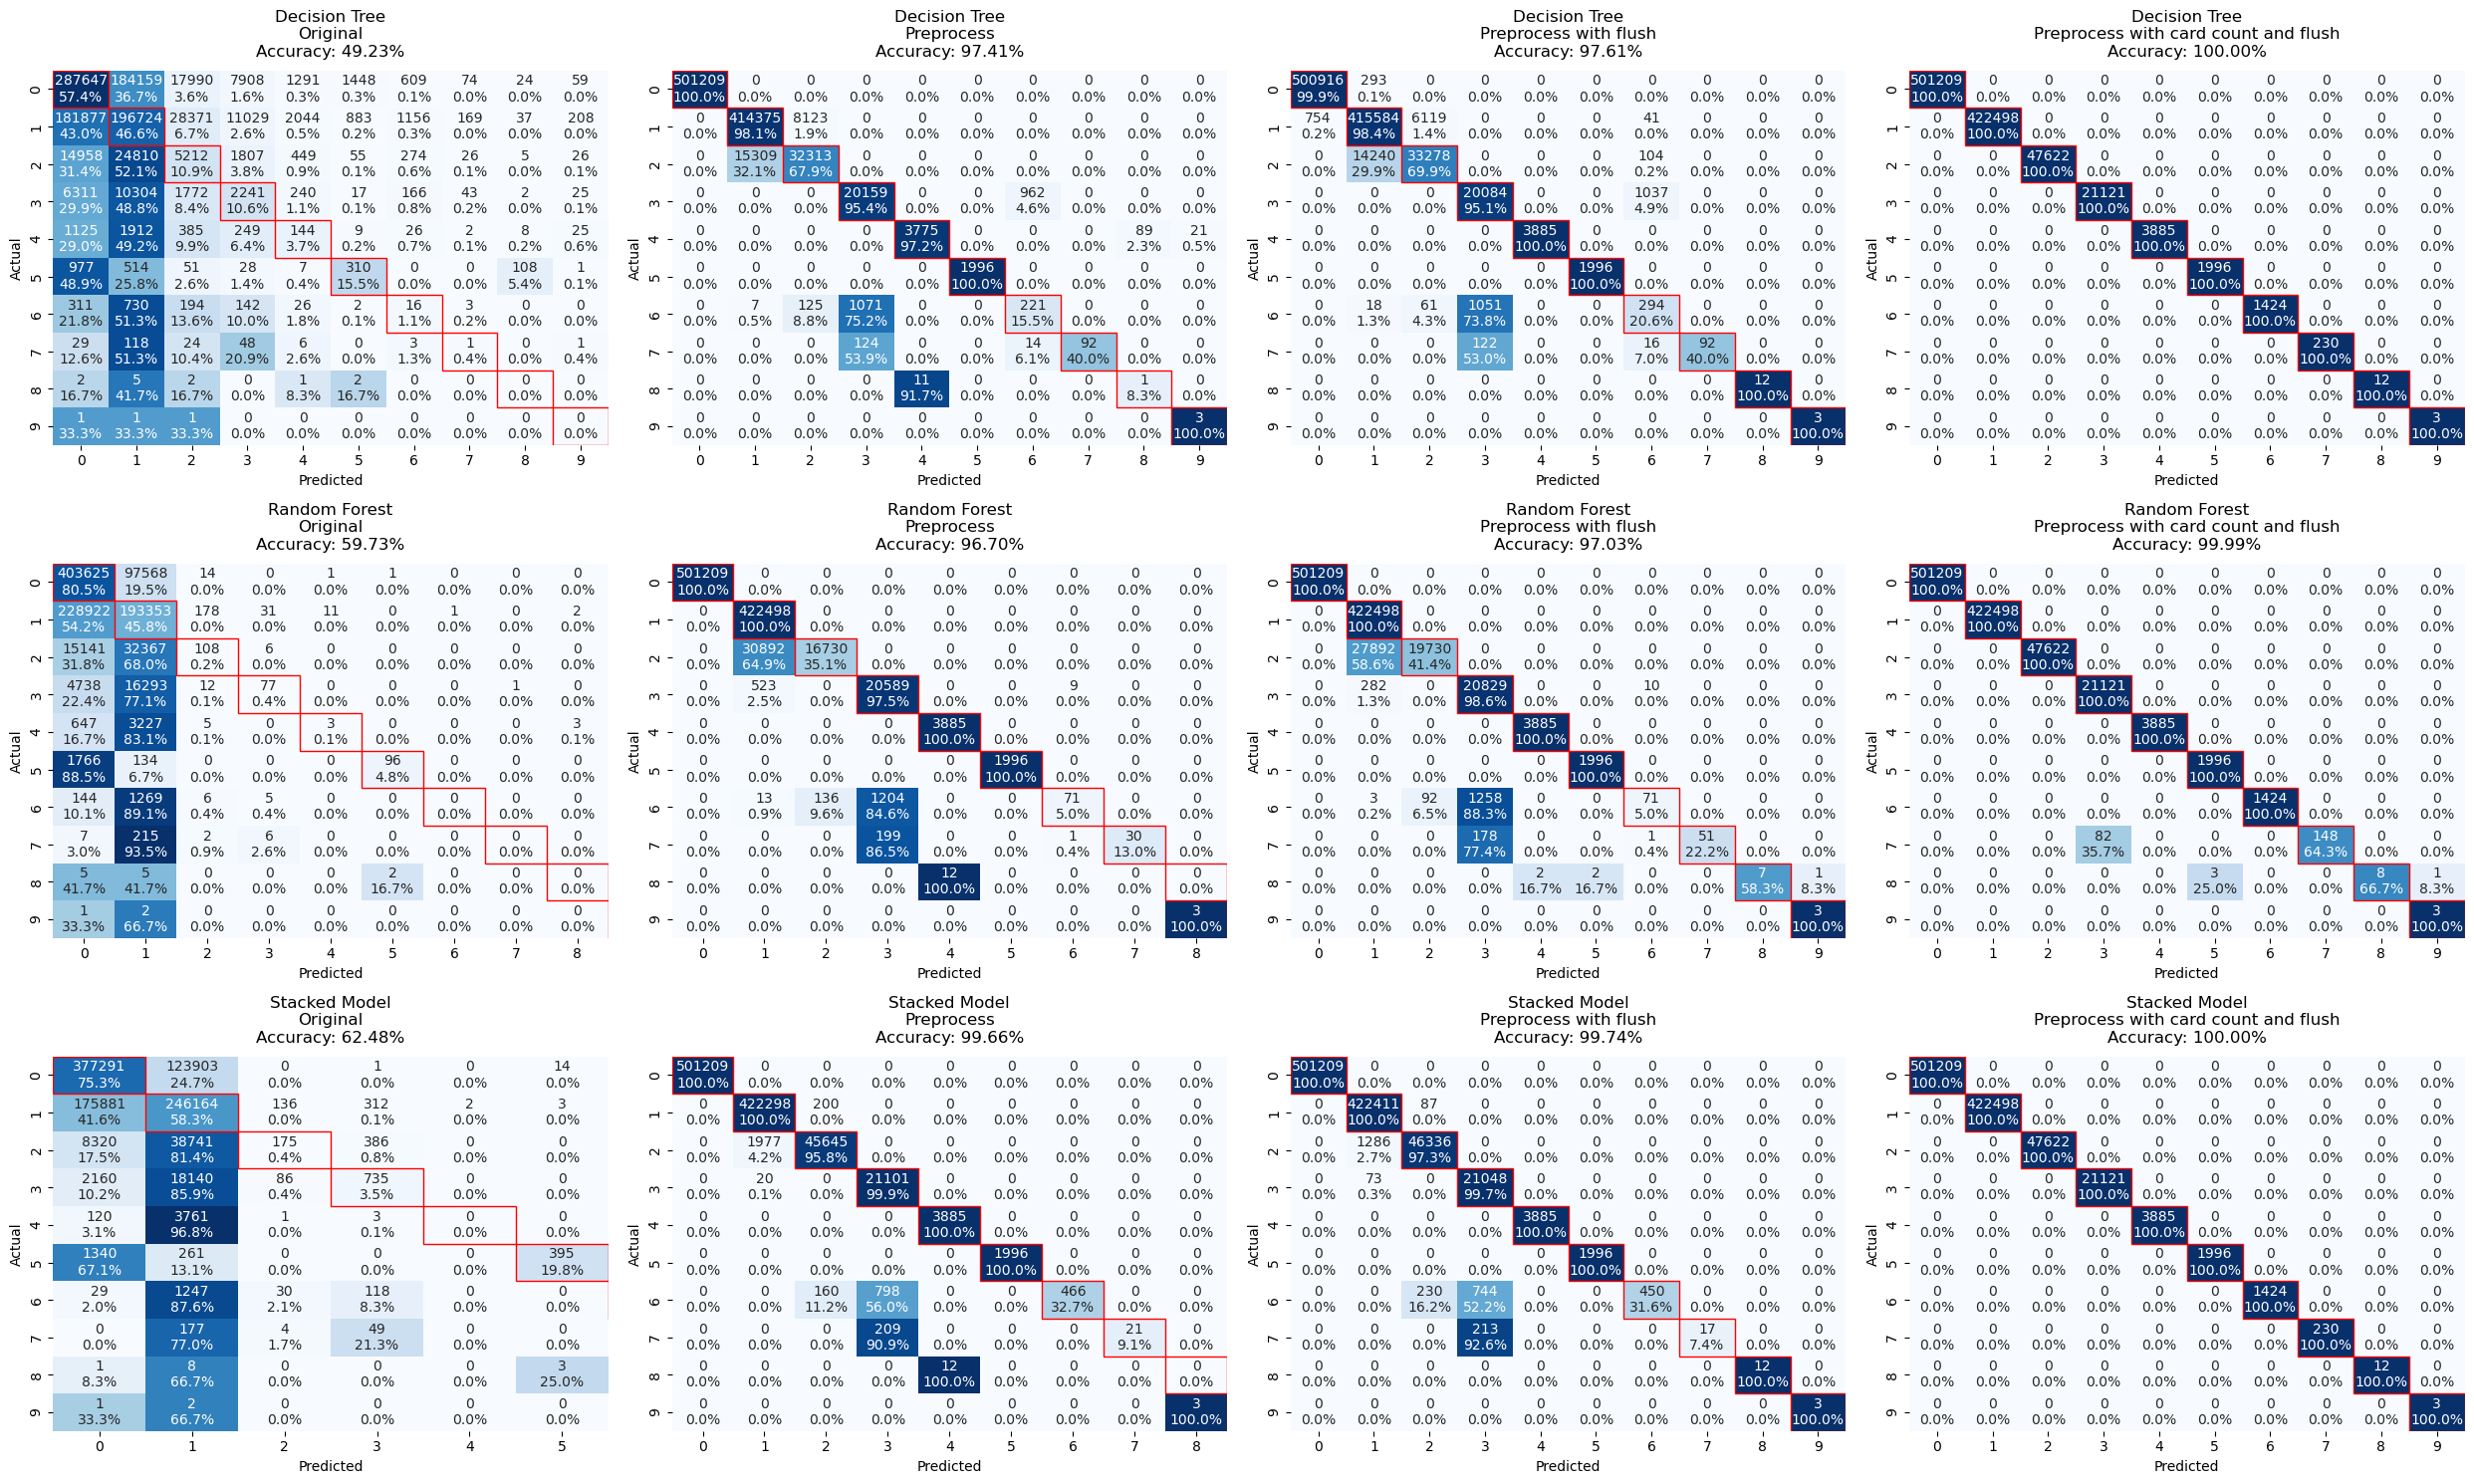

In [27]:
models = ['Decision Tree', 'Random Forest', 'Stacked Model']
preprocess_steps = ['Original', 'Preprocess', 'Preprocess with flush', 'Preprocess with card count and flush']

fig = plot_confusion_matrix_grid(matrices, accuracies, models, preprocess_steps, figsize=(25, 15))
plt.savefig("confusion_matrix_grid.png", dpi=300, bbox_inches='tight')